In [194]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SAMPLE = True

# Load Data

In [3]:
df_train = pd.read_csv(
    '../project_2/favorita-grocery-sales-forecasting/train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

if SAMPLE:
    df_train = df_train.sample(frac=0.1)

df_test = pd.read_csv(
    "../project_2/favorita-grocery-sales-forecasting/test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},\
    parse_dates=["date"]  
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

items = pd.read_csv(
    "../project_2/favorita-grocery-sales-forecasting/items.csv",
).set_index("item_nbr")

In [4]:
df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
25178089,2016-09-21,31,979553,1.386294,False
16606922,2016-06-24,41,1239741,1.386294,False
31738738,2016-11-27,44,1695932,2.558312,False
58738552,2017-08-13,6,1463566,2.397895,False
54078223,2017-06-29,54,1102268,1.098612,False


In [5]:
df_train.shape

(5903813, 5)

In [6]:
df_train.isnull().sum()

date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

In [7]:
df_train['onpromotion'].value_counts(normalize=True, dropna=False)

False    0.89397
True     0.10603
Name: onpromotion, dtype: float64

In [8]:
df_test.head()

id  onpromotion
store_nbr item_nbr date                              
1         96995    2017-08-16  125497040        False
          99197    2017-08-16  125497041        False
          103501   2017-08-16  125497042        False
          103520   2017-08-16  125497043        False
          103665   2017-08-16  125497044        False

In [9]:
df_test.shape

(3370464, 2)

In [10]:
df_test['onpromotion'].value_counts(normalize=True, dropna=False)

False    0.941077
True     0.058923
Name: onpromotion, dtype: float64

In [11]:
items.head()

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103501,CLEANING,3008,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1


In [12]:
items.shape

(4100, 3)

# Feature Engineering

Create dataframe df_2017 contains data from May 31st 2017 to upto 11 weeks i.e., May 31st 2017 - August 15 2017

In [13]:
df_2017 = df_train[df_train.date.isin(
    pd.date_range("2017-05-31", periods=7 * 11))].copy()
del df_train

In [14]:
df_2017.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
58738552,2017-08-13,6,1463566,2.397895,False
54078223,2017-06-29,54,1102268,1.098612,False
55084866,2017-07-09,12,1960892,3.555348,True
51855233,2017-06-08,44,1963606,1.098612,False
52124440,2017-06-11,17,897348,2.708050,False


In [15]:
df_2017.shape

(811243, 5)

Create promo_2017_train dataframe with promotion data from May 31st 2017 to August 15th 2017 data

In [16]:
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr","date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)

In [17]:
promo_2017_train.head()

onpromotion                                              \
date                2017-05-31 2017-06-01 2017-06-02 2017-06-03 2017-06-04   
store_nbr item_nbr                                                           
1         99197          False      False      False      False      False   
          103520         False      False      False      False      False   
          103665         False      False      False      False      False   
          105574         False      False      False      False      False   
          105575         False      False      False      False      False   

                                                                           \
date               2017-06-05 2017-06-06 2017-06-07 2017-06-08 2017-06-09   
store_nbr item_nbr                                                          
1         99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   
          105575        False      False      False      False      False   

                    ...                                              \
date                ... 2017-08-06 2017-08-07 2017-08-08 2017-08-09   
store_nbr item_nbr  ...                                               
1         99197     ...      False      False      False      False   
          103520    ...      False      False      False      False   
          103665    ...      False      False      False      False   
          105574    ...      False      False      False      False   
          105575    ...      False      False      False      False   

                                                                           \
date               2017-08-10 2017-08-11 2017-08-12 2017-08-13 2017-08-14   
store_nbr item_nbr                                                          
1         99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   
          105575        False      False      False      False      False   

                               
date               2017-08-15  
store_nbr item_nbr             
1         99197         False  
          103520        False  
          103665        False  
          105574        False  
          105575        False  

[5 rows x 77 columns]

In [18]:
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)

In [19]:
promo_2017_train.head()

date                2017-05-31  2017-06-01  2017-06-02  2017-06-03  \
store_nbr item_nbr                                                   
1         99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   
          105575         False       False       False       False   

date                2017-06-04  2017-06-05  2017-06-06  2017-06-07  \
store_nbr item_nbr                                                   
1         99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   
          105575         False       False       False       False   

date                2017-06-08  2017-06-09  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         99197          False       False  ...       False       False   
          103520         False       False  ...       False       False   
          103665         False       False  ...       False       False   
          105574         False       False  ...       False       False   
          105575         False       False  ...       False       False   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   
          105575         False       False       False       False   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         99197          False       False       False       False  
          103520         False       False       False       False  
          103665         False       False       False       False  
          105574         False       False       False       False  
          105575         False       False       False       False  

[5 rows x 77 columns]

Create promo_2017_test dataframe with promotion data from August 16th 2017 to August 31st, 2017(test data)

In [21]:
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)

In [22]:
promo_2017_test.head()

date                2017-08-16  2017-08-17  2017-08-18  2017-08-19  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103501         False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   

date                2017-08-20  2017-08-21  2017-08-22  2017-08-23  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103501         False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103501         False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995          False       False       False       False  
          99197          False       False       False       False  
          103501         False       False       False       False  
          103520         False       False       False       False  
          103665         False       False       False       False

In [23]:
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)

In [24]:
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)# Combine both train and test data of promotions

In [25]:
promo_2017.head()# May 31st - August 31st 

date                2017-05-31  2017-06-01  2017-06-02  2017-06-03  \
store_nbr item_nbr                                                   
1         99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   
          105575         False       False       False       False   

date                2017-06-04  2017-06-05  2017-06-06  2017-06-07  \
store_nbr item_nbr                                                   
1         99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   
          105575         False       False       False       False   

date                2017-06-08  2017-06-09  ...  2017-08-22  2017-08-23  \
store_nbr item_nbr                          ...                           
1         99197          False       False  ...       False       False   
          103520         False       False  ...       False       False   
          103665         False       False  ...       False       False   
          105574         False       False  ...       False       False   
          105575         False       False  ...       False       False   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   
          105575          True        True        True        True   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         99197          False       False       False       False  
          103520         False       False       False       False  
          103665         False       False       False       False  
          105574         False       False       False       False  
          105575          True        True        True        True  

[5 rows x 93 columns]

In [26]:
promo_2017.shape

(146731, 93)

In [27]:
del promo_2017_test, promo_2017_train 

In [28]:
promo_2017.columns

DatetimeIndex(['2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03',
               '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11',
               '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25', '2017-06-26', '2017-06-27',
               '2017-06-28', '2017-06-29', '2017-06-30', '2017-07-01',
               '2017-07-02', '2017-07-03', '2017-07-04', '2017-07-05',
               '2017-07-06', '2017-07-07', '2017-07-08', '2017-07-09',
               '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13',
               '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
               '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21',
               '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25',
      

In [29]:
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)
df_2017.shape

(146731, 77)

In [30]:
df_2017.head()

date                2017-05-31  2017-06-01  2017-06-02  2017-06-03  \
store_nbr item_nbr                                                   
1         99197            0.0    0.000000    0.000000    0.000000   
          103520           0.0    1.098612    0.000000    0.000000   
          103665           0.0    0.000000    0.000000    0.000000   
          105574           0.0    2.484907    1.791759    0.000000   
          105575           0.0    0.000000    2.708050    2.397895   

date                2017-06-04  2017-06-05  2017-06-06  2017-06-07  \
store_nbr item_nbr                                                   
1         99197       0.000000         0.0         0.0         0.0   
          103520      0.000000         0.0         0.0         0.0   
          103665      0.000000         0.0         0.0         0.0   
          105574      0.000000         0.0         0.0         0.0   
          105575      2.197225         0.0         0.0         0.0   

date                2017-06-08  2017-06-09  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         99197       0.000000    0.000000  ...    0.000000         0.0   
          103520      0.693147    0.000000  ...    0.000000         0.0   
          103665      0.000000    0.000000  ...    0.000000         0.0   
          105574      0.000000    2.079442  ...    0.000000         0.0   
          105575      0.000000    0.000000  ...    1.609438         0.0   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         99197       0.000000         0.0         0.0         0.0   
          103520      1.386294         0.0         0.0         0.0   
          103665      0.000000         0.0         0.0         0.0   
          105574      2.079442         0.0         0.0         0.0   
          105575      0.000000         0.0         0.0         0.0   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         99197       0.000000    0.000000         0.0         0.0  
          103520      0.693147    0.693147         0.0         0.0  
          103665      0.000000    0.000000         0.0         0.0  
          105574      0.000000    0.000000         0.0         0.0  
          105575      0.000000    0.000000         0.0         0.0  

[5 rows x 77 columns]

In [31]:
items = items.reindex(df_2017.index.get_level_values(1))
items.head()

,family,class,perishable
item_nbr,,,
99197,GROCERY I,1067,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1
105574,GROCERY I,1045,0
105575,GROCERY I,1045,0


In [32]:
items.shape

(146731, 3)

In [33]:
def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

In [34]:
def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({  
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values
    })
    for i in range(16): 
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[ 
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

# Modeling train data

In [35]:
print("Preparing dataset...")
t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26)) # Validation data
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)# test data

Preparing dataset...


In [36]:
X_train.shape

(586924, 20)

In [37]:
X_train.head()

,mean_3_2017,mean_7_2017,mean_14_2017,promo_14_2017,promo_0,promo_1,promo_2,promo_3,promo_4,promo_5,promo_6,promo_7,promo_8,promo_9,promo_10,promo_11,promo_12,promo_13,promo_14,promo_15
0,0.366204,0.156945,0.127983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.277987,0.188504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0.078472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.148532,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.627601,0.697543,0.476754,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
y_train.shape

(586924, 16)

In [39]:
y_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.30330491, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
X_val.shape

(146731, 20)

In [41]:
X_val.head()

,mean_3_2017,mean_7_2017,mean_14_2017,promo_14_2017,promo_0,promo_1,promo_2,promo_3,promo_4,promo_5,promo_6,promo_7,promo_8,promo_9,promo_10,promo_11,promo_12,promo_13,promo_14,promo_15
0,0.0,0.354987,0.255966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.000000,0.127983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.297063,0.148532,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
y_val.shape

(146731, 16)

In [43]:
y_val

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.38629436, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [44]:
X_test.shape

(146731, 20)

In [45]:
X_test.head()

,mean_3_2017,mean_7_2017,mean_14_2017,promo_14_2017,promo_0,promo_1,promo_2,promo_3,promo_4,promo_5,promo_6,promo_7,promo_8,promo_9,promo_10,promo_11,promo_12,promo_13,promo_14,promo_15
0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.231049,0.198042,0.198042,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.305476,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.308392,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1


# Build Validation and Test data

## Random Forest Regressor

In [46]:

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0,n_estimators=50,n_jobs=1,
                      oob_score=True, random_state=7,verbose=0,
                      warm_start=True)

In [47]:
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=4, n_estimators=50, n_jobs=1,
                      oob_score=True, random_state=7, warm_start=True)

In [48]:
y_pred = model.predict(X_test)

In [49]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))

Mean Absolute Error: 0.2912180622840399
Mean Squared Error: 0.40011778668829656
Root Mean Squared Error: 0.6325486437328726


## Randomized Grid Search

In [51]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [ 30,None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4,5],
               'min_samples_split': [5,10],
               'n_estimators': [30,50]}

In [52]:

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=7, n_jobs = 1)

In [53]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time= 2.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time= 2.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time= 2.0min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time= 1.9min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time= 2.0min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time= 1.8min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30; 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 5],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [30, 50]},
                   random_state=7, verbose=2)

In [54]:
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [55]:
rf_random.best_score_

0.1557164887052554

In [56]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=10,
                      n_estimators=50)

In [57]:

rf2_random=RandomForestRegressor(random_state=7, max_features='sqrt', n_estimators= 50, max_depth=30, min_samples_leaf= 4,min_samples_split=10)

In [58]:
rf2_random.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=50, random_state=7)

In [170]:
y_pred = rf2_random.predict(X_test)

In [171]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))

Mean Absolute Error: 0.2848984695296658
Mean Squared Error: 0.35448118002563733
Root Mean Squared Error: 0.5953832211488977


### Evaluation Metric in Kaggle 

Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE) = \sqrt{ \frac{\sum{i=1}^n wi \left( \ln(\hat{y}i + 1) - \ln(yi +1)  \right)^2  }{\sum{i=1}^n wi}}

In [172]:
weight = items["perishable"] * 0.25 + 1
err = (y_val - np.array(y_pred))**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

nwrmsle = 0.6092525865740591


### Feature Importance for test data

<AxesSubplot:>

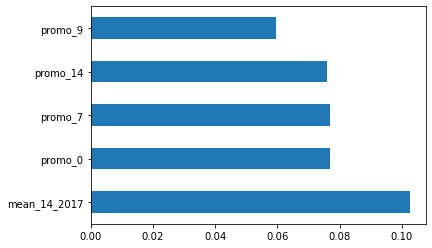

In [173]:
(pd.Series(rf2_random.feature_importances_, index=X_test.columns)
   .nlargest(5)
   .plot(kind='barh')) 

### Save predictions of test data

In [ ]:
print("Making submission...")
y_test = np.array(y_pred)
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)

### Making visualizations from test data

In [175]:
df_preds

unit_sales
store_nbr item_nbr date                  
1         99197    2017-08-16    0.072178
                   2017-08-17    0.072924
                   2017-08-18    0.075140
                   2017-08-19    0.100528
                   2017-08-20    0.100516
...                                   ...
54        2116416  2017-08-27    0.077762
                   2017-08-28    0.066316
                   2017-08-29    0.061134
                   2017-08-30    0.055668
                   2017-08-31    0.052944

[2347696 rows x 1 columns]

In [183]:
df_preds.reset_index(level = 0, inplace = True) 

In [184]:
df_preds.head()

,date,item_nbr,store_nbr,unit_sales
0,2017-08-16,99197,1,0.072178
1,2017-08-17,99197,1,0.072924
2,2017-08-18,99197,1,0.075140
3,2017-08-19,99197,1,0.100528
4,2017-08-20,99197,1,0.100516


### Top 10 items in test data

In [148]:
Item_Sales = df_preds.groupby('item_nbr').sum().sort_values("unit_sales" ,ascending=False)
Item_Sales = Item_Sales.loc[:, Item_Sales.columns.intersection(['item_nbr','unit_sales'])]

In [149]:
Item_Sales.head(10)

,unit_sales
item_nbr,
108797,505.892176
2000482,504.890795
1146786,504.829600
1012787,504.052251
1464218,501.933916
870544,501.369510
2026893,500.042503
877514,497.482497
275823,496.520697


### Predicted sales for each day in two weeks

In [190]:
df_preds["day"] =df_preds["date"].dt.day_name() 

In [191]:
df_preds.head()

,date,item_nbr,store_nbr,unit_sales,day
0,2017-08-16,99197,1,0.072178,Wednesday
1,2017-08-17,99197,1,0.072924,Thursday
2,2017-08-18,99197,1,0.075140,Friday
3,2017-08-19,99197,1,0.100528,Saturday
4,2017-08-20,99197,1,0.100516,Sunday


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

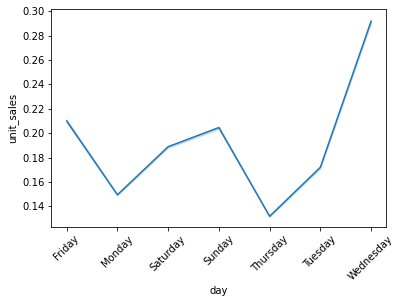

In [195]:
g =sns.lineplot(df_preds['day'],df_preds['unit_sales'])
plt.setp(g.get_xticklabels(), rotation=45)

Wednesday have most sales and Thursday have less sales

### Predicted Sales for each date in two weeks

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

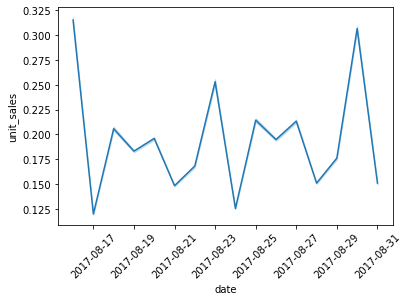

In [196]:
g =sns.lineplot(df_preds['date'],df_preds['unit_sales'])
plt.setp(g.get_xticklabels(), rotation=45)

August 16 and August 31st have most unit sales whereas August 17 and 24 have less sales